In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

def create_timeframe(X, y, t, k):
    time_data = X[t - k: t]
    time_targ = y[t - k: t]
    vali_data = X[t + 1: train_split]
    vali_targ = y[t + 1: train_split]
    return time_data, time_targ, vali_data, vali_targ

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [3]:
df = pd.read_csv("../data/daily-min-temperatures.csv")

In [4]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))

learning_rate = 0.001
epochs = 10
t, k = 2200, 1200
# reshape into X=t and Y=t+1
look_back = 1
#Create dataset creates targets as next entries value
train, test = df["Temp"].iloc[0:train_split], df["Temp"].iloc[train_split:]
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
#LSTM only accepts 3D inputs, increase dimensionality
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
#Create the timeframe w.r.t t and k values
X_train, y_train, X_val, y_val = create_timeframe(X_train, y_train, t, k)

GRU model

In [5]:
# create and fit GRU model
model2 = Sequential()
model2.add(keras.layers.GRU(32))
model2.add(Dense(1))
model2.compile(loss='mse', optimizer='adam')
path_checkpoint2 = "model_checkpoint2.h5"
es_callback2 = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback2 = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint2,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [7]:
h2 = model2.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2, validation_data=(X_val, y_val), callbacks=[es_callback2, modelckpt_callback2])


Train on 1200 samples, validate on 717 samples
Epoch 1/200
 - 2s - loss: 33.8458 - val_loss: 8.8653

Epoch 00001: val_loss improved from inf to 8.86527, saving model to model_checkpoint2.h5
Epoch 2/200
 - 1s - loss: 7.7499 - val_loss: 7.3533

Epoch 00002: val_loss improved from 8.86527 to 7.35335, saving model to model_checkpoint2.h5
Epoch 3/200
 - 1s - loss: 7.1774 - val_loss: 7.0238

Epoch 00003: val_loss improved from 7.35335 to 7.02375, saving model to model_checkpoint2.h5
Epoch 4/200
 - 1s - loss: 7.0211 - val_loss: 6.9280

Epoch 00004: val_loss improved from 7.02375 to 6.92801, saving model to model_checkpoint2.h5
Epoch 5/200
 - 1s - loss: 6.9790 - val_loss: 6.7957

Epoch 00005: val_loss improved from 6.92801 to 6.79571, saving model to model_checkpoint2.h5
Epoch 6/200
 - 1s - loss: 6.8446 - val_loss: 6.8177

Epoch 00006: val_loss did not improve from 6.79571
Epoch 7/200
 - 1s - loss: 6.8667 - val_loss: 6.8005

Epoch 00007: val_loss did not improve from 6.79571
Epoch 8/200
 - 1s

In [8]:
trainPredict2 = model2.predict(X_train)
testPredict2 = model2.predict(X_test)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Estimate model performance
trainScore2 = model2.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore2, math.sqrt(trainScore2)))
testScore2 = model2.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore2, math.sqrt(testScore2)))

Train Score: 6.77 MSE (2.60 RMSE)
Test Score: 6.27 MSE (2.50 RMSE)


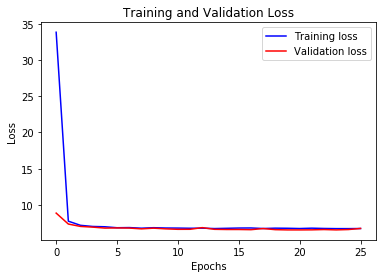

In [10]:
visualize_loss(h2, "Training and Validation Loss")